# Final Simulation Model

### Base model functionality
- Add the following properties to the Results (they should be printed when calling `print(results)`): Total cost (system cost + operating cost for 10 years), Self-consumption (PV yield used to charge trucks), load-cycles (total battery charge as a fraction of battery capacity)
- change the defaults to the following values:  
``` 
    default Battery SoC to zero
    pv_cost_pkWp = 1500
    battery_kWh: float
    battery_cost_pkWh= 300
    grid_tarif_cpkWh = 50
    grid_feedin_cpkWh = 7.06
```
- correct the `operating_cost` method to return €/a
-  `simulate()` a fleet of Etruck fleet of 5 trucks with "Workday" and 2 Trucks with "Worknight" schedule with different PV kWp and Battery kWh Sizes.
1. Simulate different Models (kWp and kWh sizes) and discuss their resulting differences: Compare a system without any PV or Battery with a more cost effective system. The total system cost without PV or Battery should be in the range of 800.000 €/10a
2. Which system configuration achieves the lowest total cost?
3. Demonstrate the correctness of your results by plotting an interesting week and discussing the observed model behaviour. 

Demonstrating these functionalities in this Notebook is mandatory and will grant you 10/20 Points of the simulation exercise.  To pass this part, 10/20 are required. To increase your points, you can additionally implement any of the following bonus objectives:

### Bonus functionalities


In [1]:
###~~~~~~~~~~~~~~~~~~~~~~~~
# Base model functionality
###~~~~~~~~~~~~~~~~~~~~~~~~
import numpy as np
import pandas as pd
import Model as m
import matplotlib.pyplot as plt
###~~~~~~~~~~~~~~~~~~~~~~~~

# Result_pvb for simulate_pvb():
class Result_pvb:
    energy_balance: pd.DataFrame
    states: pd.DataFrame
    pv_kWp: float
    pv_cost_pkWp = 1500                    # was 1000
    battery_kWh: float                     # was float
    battery_cost_pkWh= 300                 # was 300
    grid_tarif_cpkWh = 50                  # was 0.19
    grid_feedin_cpkWh = 7.06               # was 0.05
    co2_intensity = 0.270                  # kg/kWh grid
    trucks: list

    @property
    def system_cost(self):
        return self.pv_cost_pkWp*self.pv_kWp + self.battery_cost_pkWh*self.battery_kWh
    
    #> Operating cost per annum? >
    @property
    def operating_cost(self):
        return self.energy_balance["Grid to Truck"].sum()*self.grid_tarif_cpkWh - self.energy_balance["PV to Grid"].sum()*self.grid_feedin_cpkWh
    
    @property
    def emissions(self):
        return self.energy_balance["Grid to Truck"].sum()*self.co2_intensity
    
    #> Self-consumption from "PV to Grid" to "PV to Truck" >
    @property
    def self_consumption(self):
        return 1-(self.energy_balance["PV to Truck"].sum()/self.states["PV Yield"].sum())
    
    @property
    def fleet_capacity(self):
        return sum(truck.capacity_kWh for truck in self.trucks)
    
    #> Total cost for 10 years >
    @property
    def total_cost(self):
        return self.system_cost + self.operating_cost * 10 

    #> Load-cycles battery charge >
    @property
    def load_cycles(self):
        total_charge = self.total_battery_charge
        return total_charge / self.battery_kWh  
    
    #> extension from Übung 3:
    @property
    def total_battery_charge(self):
        return self.energy_balance["PV to Battery"].sum()

    @property
    def total_battery_discharge(self):
        return self.energy_balance["Battery to Truck"].sum()

    @property
    def total_energy_input(self):
        return self.energy_balance[["PV to Truck", "Battery to Truck", "Grid to Truck"]].sum().sum()

    @property
    def total_energy_output(self):
        return self.energy_balance["Driven"].sum()

    def check_battery_balance(self):
        total_charge = self.total_battery_charge
        total_discharge = self.total_battery_discharge
        print(f"Total Battery Charge: {total_charge:.2f} kWh")
        print(f"Total Battery Discharge: {total_discharge:.2f} kWh")
        if total_charge == total_discharge:
            print(">>>> ___Battery Charge = Battery Discharge___ <<<<\n")
        elif total_charge > total_discharge:
            print(">>>> ___Battery charge > Battery Discharge___ <<<<\n")
        else:
            print(">>>> ___Battery charge < Battery Discharge___ <<<<\n")

    def check_energy_balance(self):
        total_input = self.total_energy_input
        total_output = self.total_energy_output
        if total_output < 0:
            total_output = abs(total_output)
        print(f"Total Energy Input: {total_input:.2f} kWh")
        print(f"Total Energy Output from Trucks: {total_output:.2f} kWh")
        if total_input == total_output:
            print(">>>> ___Energy Input = Energy Output___ <<<<\n")
        elif total_input > total_output:
            print(">>>> ___Energy Input > Energy Output___ <<<<\n")
        else:
            print(">>>> ___Energy Input < Energy Output___ <<<<\n")
    #>>>>> until here
    
    def visualize(self, resample=(None, None)):
        states, energy_balance = self.states, self.energy_balance
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        if resample[0] is not None:
            states = states.resample(resample[0]).sum()
        if resample[1] is not None:
            energy_balance = energy_balance.resample(resample[1]).sum()
        states.plot(ax=ax[0])
        energy_balance.plot(ax=ax[1])

    #> extension from Übung 3:    
        self.check_battery_balance()
        self.check_energy_balance()
    #>>>>> until here

    def __repr__(self):
        string = f"Energy Flows: \n{self.energy_balance.sum().round()}"
        string += f'\nPV Yield: {self.states["PV Yield"].sum().round():.0f}kWh/a'
        string += f"\n{self.system_cost=:_.1f}€"
        string += f'\n{self.operating_cost=:_.1f}€/a'                               
        string += f'\n{self.emissions=:.1f}kg/a'
        string += f'\n{self.self_consumption=:.1f}kWh'                              # added
        string += f'\n{self.total_cost=:_.1f}€/10a'                                 # added
        string += f'\n{self.load_cycles=:.0f}kwh\n'                                 # added
        return string
    
#> 1) >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#> simulation pv, battery and grid included >
def simulate_pvb(
        csv_dpath = "C:\Simon\E-Post\PV_1kWp.csv",
        start_day = 0, 
        hours=8760, 
        trucks = [m.Etruck(schedule="workday")],
        pv_kWp = 200,
        battery_kWh = 2000,
        grid_threshold = 0.2):
    
    start_hour = start_day * 24
    stop_hour = start_hour + hours
    pv_raw = pv_kWp*np.genfromtxt(csv_dpath)/1000  # -> Wh > kWh/h
    pv = pv_raw[start_hour:stop_hour]
    
    battery = m.Battery()
    battery.capacity_kWh = battery_kWh
    battery.current_kWh = 0                  # This what was meant by setting default Battery SOC to 0

    energy_balance = pd.DataFrame()
    energy_balance.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]
    states = pd.DataFrame()
    states.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]

    current_kWh = np.zeros(hours)
    current_kWh[0] = sum(truck.current_kWh for truck in trucks)
    battery_SOC_kWh = np.zeros(hours)

    gridcharge_kWh = np.zeros(hours)          # Grid > truck
    pvcharge_kWh = np.zeros(hours)            # PV > Truck
    battery_to_truck_kWh = np.zeros(hours)    # battery > Truck
    pv_to_battery_kWh = np.zeros(hours)
    pv_to_grid_kWh = np.zeros(hours)
    driven_kWh = np.zeros(hours)

    for h in range(hours):
        i = energy_balance.index[h]
        hd = i.hour
        wd = i.weekday()

        dispatchable_PV = pv[h]
        for truck in trucks:
            if truck.status(hd, wd) == "onsite":
                pv_used_in_truck = truck.charge(dispatchable_PV)
                pvcharge_kWh[h] += pv_used_in_truck
                dispatchable_PV -= pv_used_in_truck

                batt_used_in_truck = truck.charge(battery.max_discharge)
                battery.discharge(batt_used_in_truck)
                battery_SOC_kWh[h] -= batt_used_in_truck
                battery_to_truck_kWh[h] += batt_used_in_truck
                
                if truck.SoC < grid_threshold:
                    difference_kWh = (grid_threshold - truck.SoC)*truck.capacity_kWh
                    gridcharge_kWh[h] += truck.charge(difference_kWh)
            
            if truck.status(hd, wd) == "offsite":
                driven_kWh[h] += truck.discharge(truck.avg_km_per_h*truck.consumption)
                
            current_kWh[h] += truck.current_kWh
        
        pv_to_battery_kWh[h] = battery.charge(dispatchable_PV)
        pv_to_grid_kWh[h] = dispatchable_PV - pv_to_battery_kWh[h]
        battery_SOC_kWh[h] = battery.current_kWh
    
    states["PV Yield"] = pv
    states["Fleet SOC"] = current_kWh
    states["Battery SOC"] = battery_SOC_kWh
    energy_balance["Grid"] = gridcharge_kWh
    energy_balance["PV to Truck"] = pvcharge_kWh
    energy_balance["PV to Battery"] = pv_to_battery_kWh
    energy_balance["PV to Grid"] = pv_to_grid_kWh
    energy_balance["Battery to Truck"] = battery_to_truck_kWh
    energy_balance["Grid to Truck"] = gridcharge_kWh
    energy_balance["Driven"] = -driven_kWh

    results = Result_pvb()

    results.energy_balance = energy_balance
    results.states = states
    results.battery_kWh = battery_kWh
    results.pv_kWp = pv_kWp
    results.trucks = trucks

    return results

In [2]:
# Result_ for simulate_pv(), modifying battery enegy balance to grid energy balance:
class Result_:
    energy_balance: pd.DataFrame
    states: pd.DataFrame
    pv_kWp: float
    pv_cost_pkWp = 1500                    # was 1000
    grid_tarif_cpkWh = 50                  # was 0,19
    grid_feedin_cpkWh = 7.06               # was 0.05
    co2_intensity = 0.270                  # kg/kWh grid
    trucks: list

    @property
    def system_cost(self):
        return self.pv_cost_pkWp*self.pv_kWp 
    
    #> Operating cost (€/a) >
    @property
    def operating_cost(self):
        return self.energy_balance["Grid to Truck"].sum()*self.grid_tarif_cpkWh - self.energy_balance["PV to Grid"].sum()*self.grid_feedin_cpkWh
    
    @property
    def emissions(self):
        return self.energy_balance["Grid to Truck"].sum()*self.co2_intensity
    
    #> Self-consumption PV to Truck (was PV to Grid) >
    @property
    def self_consumption(self):
        return 1-(self.energy_balance["PV to Truck"].sum()/self.states["PV Yield"].sum())
    
    @property
    def fleet_capacity(self):
        return sum(truck.capacity_kWh for truck in self.trucks)
    
    #> Total cost for 10 years >
    @property
    def total_cost(self):
        return self.system_cost + self.operating_cost * 10 
    
    @property
    def total_grid_charge(self):
        return self.energy_balance["PV to Grid"].sum()

    @property
    def total_grid_discharge(self):
        return self.energy_balance["Grid to Truck"].sum()

    @property
    def total_energy_input(self):
        return self.energy_balance[["PV to Truck", "Grid to Truck"]].sum().sum()

    @property
    def total_energy_output(self):
        return self.energy_balance["Driven"].sum()
    
    def check_grid_balance(self):
        total_charge = self.total_grid_charge
        total_discharge = self.total_grid_discharge
        print(f"Total Grid Charge: {total_charge:.2f} kWh")
        print(f"Total Grid Discharge: {total_discharge:.2f} kWh")
        if total_charge == total_discharge:
            print(">>>> ___Grid Charge = Grid Discharge___ <<<<\n")
        elif total_charge > total_discharge:
            print(">>>> ___Grid charge > Grid Discharge___ <<<<\n")
        else:
            print(">>>> ___Grid charge < Grid Discharge___ <<<<\n")

    def check_energy_balance(self):
        total_input = self.total_energy_input
        total_output = self.total_energy_output
        if total_output < 0:
            total_output = abs(total_output)
        print(f"Total Energy Input: {total_input:.2f} kWh")
        print(f"Total Energy Output from Trucks: {total_output:.2f} kWh")
        if total_input == total_output:
            print(">>>> ___Energy Input = Energy Output___ <<<<\n")
        elif total_input > total_output:
            print(">>>> ___Energy Input > Energy Output___ <<<<\n")
        else:
            print(">>>> ___Energy Input < Energy Output___ <<<<\n")
    
    def visualize(self, resample=(None, None)):
        states, energy_balance = self.states, self.energy_balance
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        if resample[0] is not None:
            states = states.resample(resample[0]).sum()
        if resample[1] is not None:
            energy_balance = energy_balance.resample(resample[1]).sum()
        states.plot(ax=ax[0])
        energy_balance.plot(ax=ax[1])
        
        self.check_grid_balance()
        self.check_energy_balance()
        
    def __repr__(self):
        string = f"Energy Flows: \n{self.energy_balance.sum().round()}"
        string += f'\nPV Yield: {self.states["PV Yield"].sum().round():.0f}kWh/a'
        string += f"\n{self.system_cost=:_.1f}€"
        string += f'\n{self.operating_cost=:_.1f}€/a'                               
        string += f'\n{self.emissions=:.1f}kg/a'
        string += f'\n{self.self_consumption=:.1f}kWh'                              # added
        string += f'\n{self.total_cost=:_.1f}€/10a\n'                                 # added
        return string


#> 2) >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#> simulation pv and grid, battery excluded >
def simulate_pv(
        csv_dpath = "C:\Simon\E-Post\PV_1kWp.csv",
        start_day = 0, 
        hours=8760, 
        trucks = [m.Etruck(schedule="workday")],
        pv_kWp = 200,
        grid_threshold = 0.2):
    
    start_hour = start_day * 24
    stop_hour = start_hour + hours
    pv_raw = pv_kWp*np.genfromtxt(csv_dpath)/1000  # -> Wh > kWh/h
    pv = pv_raw[start_hour:stop_hour]

    energy_balance = pd.DataFrame()
    energy_balance.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]
    states = pd.DataFrame()
    states.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]

    current_kWh = np.zeros(hours)
    current_kWh[0] = sum(truck.current_kWh for truck in trucks)

    gridcharge_kWh = np.zeros(hours)          # Grid > truck
    pvcharge_kWh = np.zeros(hours)            # PV > Truck
    pv_to_grid_kWh = np.zeros(hours)
    driven_kWh = np.zeros(hours)

    for h in range(hours):
        i = energy_balance.index[h]
        hd = i.hour
        wd = i.weekday()

        dispatchable_PV = pv[h]
        for truck in trucks:
            if truck.status(hd, wd) == "onsite":
                pv_used_in_truck = truck.charge(dispatchable_PV)
                pvcharge_kWh[h] += pv_used_in_truck
                dispatchable_PV -= pv_used_in_truck
                
                if truck.SoC < grid_threshold:
                    difference_kWh = (grid_threshold - truck.SoC)*truck.capacity_kWh
                    gridcharge_kWh[h] += truck.charge(difference_kWh)
            
            if truck.status(hd, wd) == "offsite":
                driven_kWh[h] += truck.discharge(truck.avg_km_per_h*truck.consumption)
                
            current_kWh[h] += truck.current_kWh
        
        pv_to_grid_kWh[h] = dispatchable_PV 
    
    states["PV Yield"] = pv
    states["Fleet SOC"] = current_kWh
    energy_balance["Grid"] = gridcharge_kWh
    energy_balance["PV to Truck"] = pvcharge_kWh
    energy_balance["PV to Grid"] = pv_to_grid_kWh
    energy_balance["Grid to Truck"] = gridcharge_kWh
    energy_balance["Driven"] = -driven_kWh

    results = Result_()

    results.energy_balance = energy_balance
    results.states = states
    results.pv_kWp = pv_kWp
    results.trucks = trucks

    return results


In [3]:
# a fleet of 7 trucks
fleet_trucks = np.concatenate((np.repeat([m.Etruck(schedule="workday")], 5), 
                               np.repeat([m.Etruck(schedule="worknight")], 2))).tolist()

In [4]:
# battery_kWh = b_kWh, pv_kWp = pv_kWo 
b_kWh = 1500  #  1500?
pv_kWo = 198  #  from 199 operating cost takes negative values

# tw options simulate_pv() ~ without battery
# or simulate_pvb() ~ with battery
# I choose pv and battery:
results01_pvb = simulate_pvb(trucks=fleet_trucks, battery_kWh=b_kWh, pv_kWp=pv_kWo)
#print(results01_pvb)
#results01_pvb.visualize(("M", "M"))
print(results01_pvb.system_cost)
print(results01_pvb.operating_cost)
print(results01_pvb)


747000
141359.18221512507
Energy Flows: 
Grid                 11992.0
PV to Truck          40297.0
PV to Battery       100387.0
PV to Grid           64909.0
Battery to Truck    100387.0
Grid to Truck        11992.0
Driven             -153442.0
dtype: float64
PV Yield: 205593kWh/a
self.system_cost=747_000.0€
self.operating_cost=141_359.2€/a
self.emissions=3237.9kg/a
self.self_consumption=0.8kWh
self.total_cost=2_160_591.8€/10a
self.load_cycles=67kwh



# EcoExt module 

Goals:
1) to create an economic extension module that uses the outputs of the simulation model, 
2) to visualise the results,
3) to conduct some simulations,
4) analyse the usefullness of such a tool.

Specific tasks:
1) amortisation schedule,
2) cash flow,
3) net present value (NPV).

Methods: creating EcoExt module called EcoExt.py, conducting amortisation schedule, visualising its results, 
conducting annual interest rate in dependence of running years simulation, its visualisation,
obtaining cash-flow, calculating NPV on cash-flow with inflation,
simulating NPV on csah-flow in  dependence of various inflation rates.

Results:
1) The higher interest rates the higher the monthly payback. 
2) The shorter the amortisation period the higher the amount of mothly payback.
3) Higher inflation rates decrease NPVs (that are negative). 
4) Increasing annual interest rates also increase this negative tendency (decrease NPVs).

Discussion: 
1) Decisions about optimal amortisation period and interest rate can be obtained on optimised E-Post models.
2) Various parameter set combinations (capital cost, own capital, running years, payment interval, annual interest rate) help to create an amortisation schedule that 
3) can be simulated to help economic investment decisions.
4) Combining E-Post simulation with the economic extension tool is good decision making framework.

Conclusions: economic extension tool was introduced that is based on the cost related outputs of the optimised E-Post simulation model. Combination of the two tools is a promising method both for E-Post optimisation and its economic investment optimisation. Thus, finding the most cost-efficient system is possible.



In [5]:
import EcoExt as eco

# Input Parameter set:
PV = results01_pvb.system_cost         # capital cost = system cost 
POC = 25                               # procent of capital cost or system_cost -> borrowed loan is 0.75*system cost
r = 0.085                              # annual interest rate
monthly = 12                           # payment 12 months a year
ny = 10                                # 10 years running

# Function call
amort_instance = eco.Amort(PV, POC, r, monthly, ny)

# Results
schedule = amort_instance.amortisation_schedule()
schedule[0:10]

,Principal,Interest,Payment,Balance,Period
0,2929.003843,3968.437500,6897.441343,557320.996157,1
1,2949.750954,3947.690389,6897.441343,554371.245203,2
2,2970.645023,3926.796320,6897.441343,551400.600181,3
3,2991.687092,3905.754251,6897.441343,548408.913089,4
4,3012.878209,3884.563134,6897.441343,545396.034880,5
5,3034.219429,3863.221914,6897.441343,542361.815451,6
6,3055.711817,3841.729526,6897.441343,539306.103634,7
7,3077.356442,3820.084901,6897.441343,536228.747192,8
8,3099.154384,3798.286959,6897.441343,533129.592808,9
9,3121.106727,3776.334616,6897.441343,530008.486081,10


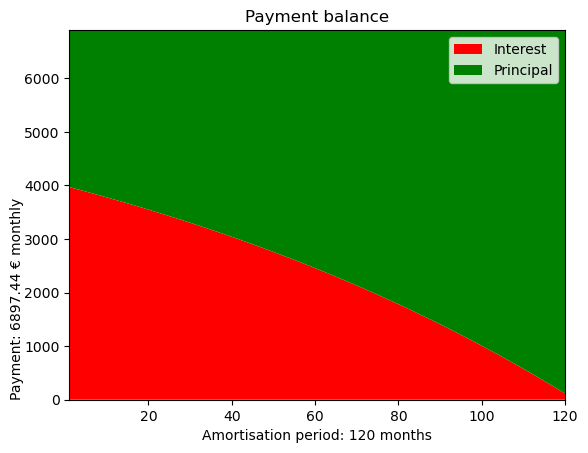

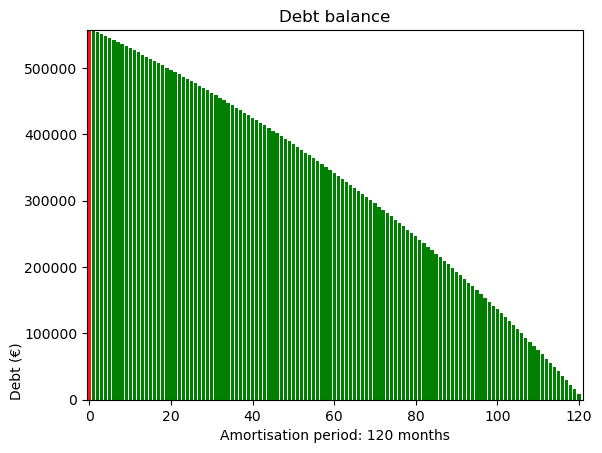

In [6]:
# Visualising results
plotter = eco.AmortPlot(schedule)
plotter.plot_payment_balance()
plotter.plot_loan_balance()

In [7]:
# Let's conduct some simulation

# Variuos annual interest rates and running years
a_irs = [0.085, 0.08, 0.07, 0.05, 0.03]
y = [5, 10, 15]

# Their combinations
def combine(list1, list2):
    combo = []
    for i in range(len(list1)):
        for j in range(len(list2)):
            combo.append((list1[i], list2[j]))
    return(pd.DataFrame(combo))

df_combo = combine(a_irs, y)
df_combo = df_combo.rename(columns={0: "Annual_ir", 1: "Years"})

# Loop
dic = {}
for i in range(df_combo.shape[0]):
    indic = eco.Amort(PV, POC, df_combo.Annual_ir[i], monthly, df_combo.Years[i])
    dic[i] = indic.amortisation_schedule()
    dic[i]["Annual_ir"] = df_combo.Annual_ir[i]
    dic[i]["Years"] = df_combo.Years[i]

    
# Data frame result
df_dic = pd.concat(dic.values(), ignore_index=True)
df_dic

,Principal,Interest,Payment,Balance,Period,Annual_ir,Years
0,7445.103262,3968.437500,11413.540762,552804.896738,1,0.085,5
1,7497.839410,3915.701352,11413.540762,545307.057327,2,0.085,5
2,7550.949106,3862.591656,11413.540762,537756.108221,3,0.085,5
3,7604.434996,3809.105767,11413.540762,530151.673226,4,0.085,5
4,7658.299744,3755.241019,11413.540762,522493.373482,5,0.085,5
...,...,...,...,...,...,...,...
1795,3806.046474,53.288827,3859.335301,17509.484519,176,0.030,15
1796,3815.561590,43.773711,3859.335301,13693.922929,177,0.030,15
1797,3825.100494,34.234807,3859.335301,9868.822435,178,0.030,15
1798,3834.663245,24.672056,3859.335301,6034.159190,179,0.030,15


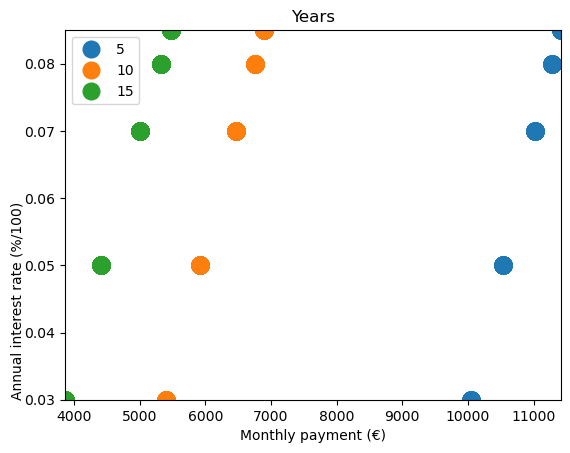

In [8]:
# Visualisation of monthly payment depending on annual interest rates and running years
eco.SimPlot(df_dic, 
            groupBY = "Years", 
            x = "Payment", 
            y = "Annual_ir",
            xlab = "Monthly payment (€)", 
            ylab = "Annual interest rate (%/100)")

In [10]:
# Determining cash flow: since there is only one inflow (loan) the rest are outflows (+ loan - capital cost - operating cost - monthly payment of the borrowed loan)

# Function:
def get_cash_flow(operating_cost,         # output of E-post simulation
                  system_cost,            # output of E-post simulation
                  amort,                  # output of eco.Amort()
                  payments_per_year,      # normally monthly payment (12) of borrowed loan
                  years,                  # duration of loan payback
                  procent_own_capital):   # of capital cost, rest is loan
    
    #~ 1 ~# -monthly operating costs - monthly payment (refer to figure Payement balance)
    cash_flowOUT = np.repeat(round(-(operating_cost/years/payments_per_year)-amort.Payment[0], 2), amort.shape[0]-1).tolist() 
    #~ 2 ~# -system cost*0.25 = -(loan - capital cost)
    cash_flowOUT.insert(0, -system_cost*(procent_own_capital/100))
    return(cash_flowOUT)


# obtain cash flow
cash_flow = get_cash_flow(results01_pvb.operating_cost,
                          results01_pvb.system_cost,
                          schedule,
                          monthly,
                          ny,
                          25)

cash_flow[0:10]

[-186750.0,
 -8075.43,
 -8075.43,
 -8075.43,
 -8075.43,
 -8075.43,
 -8075.43,
 -8075.43,
 -8075.43,
 -8075.43]

In [11]:
# Net Present Value on cash_flow and loan amortisation with infaltion (expected price increases) rate 

# Input parameter (new):
inflat = 0.02                                  # expected price increases are expressed in inflation (%/100)

# Function call
npv_instance = eco.NPV(capital_cost=PV,
                  annual_interest_rate=r,
                  payments_per_year=monthly,
                  years=ny,
                  inflation=inflat,                      
                  cash_flow=cash_flow,         # above generated cash_flow of the E-Post simulation model results
                  amort=schedule,              # output of eco.Amort()
                  get_print=True)              # if get_print=False, only data frame is returned (no print of the results)

# Results
npv_instance.npv()


NPV: -828737.39 €
Inflation adjusted NPV: -775239.15 €
Loan amortisation NPV: 1294142.63 €



,npv,npv_inf,npv_loanp
0,-828737.385282,-775239.150212,1.294143e+06


In [12]:
# Let's do some simulation

# Various annual ineterest rates and inflations
a_irs = [0.085, 0.08, 0.07, 0.05, 0.03]
infl = [0.02, 0.03, 0.05]

# Their combinations
df_combo = combine(a_irs, infl)
df_combo = df_combo.rename(columns={0: "Annual_ir", 1: "Inflation"})

# Loop
dic = {}
for i in range(df_combo.shape[0]):
    indic = eco.NPV(capital_cost=PV,
                  annual_interest_rate=df_combo.Annual_ir[i],
                  payments_per_year=monthly,
                  years=ny,
                  inflation=df_combo.Inflation[i],
                  cash_flow=cash_flow,
                  amort=schedule,
                  get_print=False)
    dic[i] = indic.npv()
    
# Data frame result
df_dic = pd.concat(dic.values(), ignore_index=True)
df_plot = pd.concat([df_combo, df_dic], axis = 1)
df_plot

,Annual_ir,Inflation,npv,npv_inf,npv_loanp
0,0.085,0.02,-8.287374e+05,-775239.150212,1.294143e+06
1,0.085,0.03,-8.287374e+05,-750852.600736,1.294143e+06
2,0.085,0.05,-8.287374e+05,-706269.141707,1.294143e+06
3,0.080,0.02,-8.430802e+05,-787931.875528,1.306785e+06
4,0.080,0.03,-8.430802e+05,-762805.224155,1.306785e+06
5,0.080,0.05,-8.430802e+05,-716890.576906,1.306785e+06
6,0.070,0.02,-8.731457e+05,-814513.256852,1.333274e+06
7,0.070,0.03,-8.731457e+05,-787824.674041,1.333274e+06
8,0.070,0.05,-8.731457e+05,-739102.044339,1.333274e+06
9,0.050,0.02,-9.392956e+05,-872887.261076,1.391502e+06


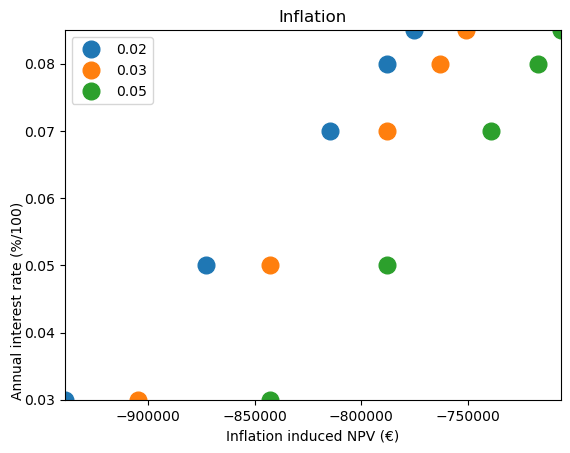

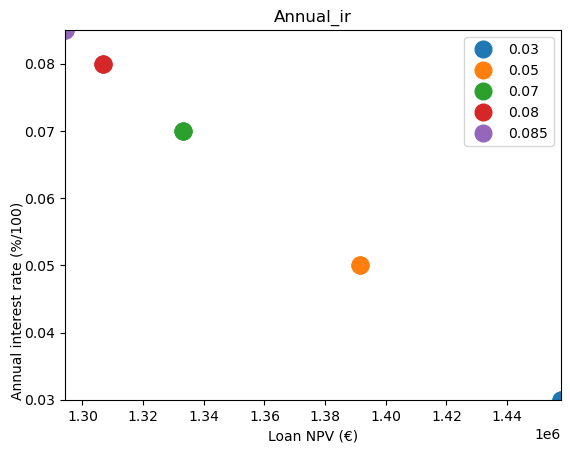

In [13]:
# Plotting inflation induced NPV in dependence of various interest rates:

eco.SimPlot(df_plot, 
            groupBY = "Inflation", 
            x = "npv_inf", 
            y = "Annual_ir", 
            xlab = "Inflation induced NPV (€)", 
            ylab = "Annual interest rate (%/100)")

# Plotting loan NPV in dependence of annual interest rates:
eco.SimPlot(df_plot, 
            groupBY = "Annual_ir", 
            x = "npv_loanp", 
            y = "Annual_ir", 
            xlab = "Loan NPV (€)", 
            ylab = "Annual interest rate (%/100)")